In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline

In [153]:
!pip install descartes

In [214]:
import shapely

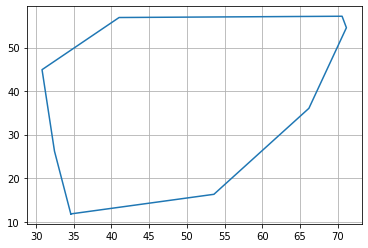

In [4]:
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

def generateConvexPolygon(n):
    MAX_COORD = 50
    pts = MAX_COORD * np.random.rand(n, 2)
    x, y = pts[:,0], pts[:,1]
    x = x[1:] + [x[1]]
    y = y[1:] + [y[1]]
    poly = Polygon(zip(x, y))
    convex_hull_x, convex_hull_y = [z.tolist() for z in poly.convex_hull.exterior.coords.xy]
    return (convex_hull_x, convex_hull_y)
    

def generateRectilinearPolygon(n):
    pass

def drawPolygonByHull(hull_x, hull_y):
    plt.plot(hull_x, hull_y)
    plt.grid(True)
    plt.show()
    
hull_x, hull_y = generateConvexPolygon(10)
drawPolygonByHull(hull_x, hull_y)

noisePoint:  (24.70284986653516, 17.225931862638667)


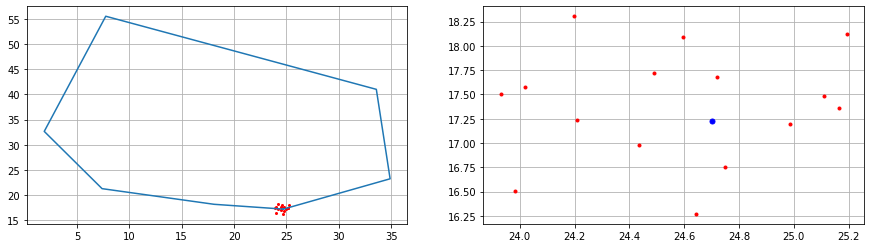

In [5]:
def addNormalNoiseAroundPoint(point, n=5, mu=0.0, sigma=0.1, alpha=10):
    # point is (x, y)    
    mu, sigma = 0, 0.1 # mean and standard deviation
    x_noise = point[0] + alpha * np.random.normal(mu, sigma, n)
    y_noise = point[1] + alpha * np.random.normal(mu, sigma, n)
    return x_noise, y_noise

hull_x, hull_y = generateConvexPolygon(10)

noisePoint = (hull_x[0], hull_y[0])
print('noisePoint: ', noisePoint)


noise_x, noise_y = addNormalNoiseAroundPoint(noisePoint, n=15,  mu=0, sigma=0.1, alpha=5)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(noise_x, noise_y, 'ro', c='red', alpha=1, markersize=2)
ax[0].plot(hull_x, hull_y)
ax[0].grid(True)


ax[1].plot(noise_x, noise_y, 'ro', c='red', alpha=1, markersize=3)
ax[1].plot(noisePoint[0], noisePoint[1], 'ro', c='blue', alpha=1, markersize=5)
ax[1].grid(True)

plt.show()

(24.70284986653516, 17.225931862638667) (18.089568800175307, 18.179891285448903)


/home/yaroslav/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


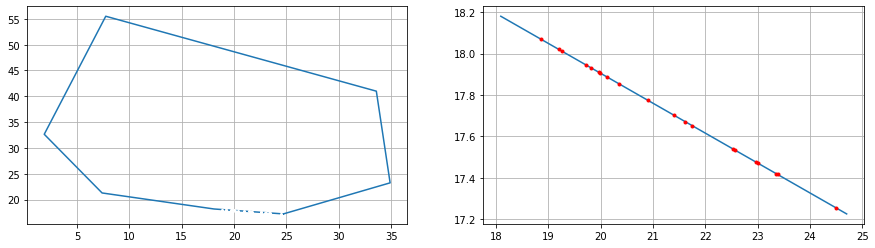

In [7]:
from scipy.stats import uniform
from numpy import ones,vstack
from numpy.linalg import lstsq

def deleteRandomPointsOnEdge(p1, p2, n=20):
    # delete n random points on edge by uniform distribution
    
    def y(x, m, c):
        return m * x + c
    
    points = [p1, p2]
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]
    # Line Solution is y = mx + c

    xMax, xMin = max(p1[0], p2[0]), min(p1[0], p2[0])
    L = xMax - xMin
    
    x_delete = xMin + L * np.random.rand(n)
    y_delete = np.array([y(x, m, c) for x in x_delete])
    
    return (x_delete, y_delete)

p1 = (hull_x[0], hull_y[0])
p2 = (hull_x[1], hull_y[1])

print(p1, p2)
x_delete, y_delete = deleteRandomPointsOnEdge(p1, p2)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# ax[0].plot(noise_x, noise_y, 'ro', c='red', alpha=1, markersize=2)
ax[0].plot(hull_x, hull_y)
ax[0].plot(x_delete, y_delete, 'ro', c='white', alpha=1, markersize=2)
ax[0].grid(True)


ax[1].plot([p1[0], p2[0]], [p1[1], p2[1]], alpha=1, markersize=3)
ax[1].plot(x_delete, y_delete, 'ro', c='red', alpha=1, markersize=3)
# ax[1].plot(noisePoint[0], noisePoint[1], 'ro', c='blue', alpha=1, markersize=5)
ax[1].grid(True)

plt.show()

In [15]:
!wget https://raw.githubusercontent.com/stepmat/rectilinear_polygon_generator/master/blank.png

--2020-05-25 12:57:21--  https://raw.githubusercontent.com/stepmat/rectilinear_polygon_generator/master/blank.png
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 151.101.244.133
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 20069 (20K) [image/png]
Сохранение в: «blank.png»

blank.png           100%[===================>]  19,60K  --.-KB/s    за 0,03s   

2020-05-25 12:57:21 (769 KB/s) - «blank.png» сохранён [20069/20069]



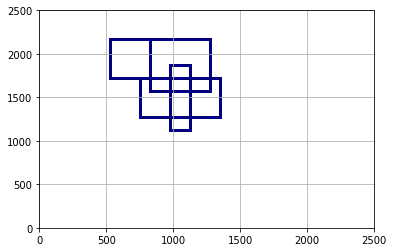

In [265]:
# https://github.com/stepmat/rectilinear_polygon_generator/blob/master/generate_polygon.py

import sys
import cv2
import numpy
import copy
import scipy.misc
import itertools
from PIL import Image, ImageOps, ImageDraw
from scipy.ndimage import morphology, label
from copy import deepcopy
from operator import itemgetter
from statistics import median, mean
from math import sqrt
from random import randint



# generation parameters (CAN CHANGE)
num_rect = 4 # randint(5, 15) # rect. .nums
canvas_width = 20 
canvas_height = 20
min_size = 1
max_size = 5
increments = 150

# # Basic vision
# orig = Image.open("blank.png")                      # must feed in blank, black canvas image as input (blank.png)
# img = ImageOps.grayscale(orig)
# im = numpy.array(img)
# im = morphology.grey_dilation(im, (3, 3)) - im      # inner morphological gradient
# img = Image.fromarray(im)
# visual = img.convert('RGB')
# draw = ImageDraw.Draw(visual)



# Generate random number of rectangles (must be touching) of random sizes
boxes = []
for i in range(num_rect):
    valid = 0
    while(valid == 0):
        width = randint(min_size, max_size)*increments
        height = randint(min_size, max_size)*increments
        pos_x = randint(max_size+1, canvas_width-max_size-1)*increments
        pos_y = randint(max_size+1, canvas_height-max_size-1)*increments
        for j in boxes:
            touching = 1
            if (pos_x+(width/2.0) < j[0]-(j[2]/2.0)):
                touching = 0
            if (pos_x-(width/2.0) > j[0]+(j[2]/2.0)):
                touching = 0
            if (pos_y+(height/2.0) < j[1]-(j[3]/2.0)):
                touching = 0
            if (pos_y-(height/2.0) > j[1]+(j[3]/2.0)):
                touching = 0
            if touching == 1:
                valid = 1
        if len(boxes) == 0:
            valid = 1
    boxes.append([pos_x,pos_y,width,height])
# for i in boxes:
#     print(i)
# print('******************')


# Extend those that stick out to the ground
bottom_ground = 0
for i in boxes:
    if (i[1] + (i[3]/2.0)) > bottom_ground:
        bottom_ground = (i[1] + (i[3]/2.0))

for i in range(len(boxes)):
    bottom_left = [boxes[i][0]-(boxes[i][2]/2.0),boxes[i][1]+(boxes[i][3]/2.0)]
    bottom_right = [boxes[i][0]+(boxes[i][2]/2.0),boxes[i][1]+(boxes[i][3]/2.0)]
    line_check = [bottom_left,bottom_right]
    intersect = 0
    for j in range(len(boxes)):
        if i!=j:
            p1 = [boxes[j][0]-(boxes[j][2]/2.0),boxes[j][1]-(boxes[j][3]/2.0)-1]
            p2 = [boxes[j][0]-(boxes[j][2]/2.0),boxes[j][1]+(boxes[j][3]/2.0)+1]
            p3 = [boxes[j][0]+(boxes[j][2]/2.0),boxes[j][1]-(boxes[j][3]/2.0)-1]
            p4 = [boxes[j][0]+(boxes[j][2]/2.0),boxes[j][1]+(boxes[j][3]/2.0)+1]
            line_check2 = [p1,p2]
            line_check3 = [p3,p4]
            if (line_check[0][0] < line_check2[0][0]) and (line_check[1][0] > line_check2[0][0]):
                if (line_check[0][1] > line_check2[0][1]) and (line_check[0][1] < line_check2[1][1]):
                    intersect = 1
            if (line_check[0][0] < line_check3[0][0]) and (line_check[1][0] > line_check3[0][0]):
                if (line_check[0][1] > line_check3[0][1]) and (line_check[0][1] < line_check3[1][1]):
                    intersect = 1
            if (line_check[0][0] > line_check2[0][0]) and (line_check[1][0] > line_check2[0][0]):
                if (line_check[0][0] < line_check3[0][0]) and (line_check[1][0] < line_check3[0][0]):
                    if (line_check[0][1] > line_check2[0][1]) and (line_check[0][1] < line_check2[1][1]):
                        intersect = 1
    if intersect == 0:
        current_bottom = boxes[i][1] + (boxes[i][3]/2.0)
        to_add = bottom_ground-current_bottom
        boxes[i][3] = boxes[i][3] + to_add
        boxes[i][1] = boxes[i][1] + (to_add/2.0)
        


# Draw resulting rectangles as image
tlbr = []
for i in boxes:
    top_left = (i[0]-(i[2]/2.0),i[1]-(i[3]/2.0))
    bottom_right = (i[0]+(i[2]/2.0),i[1]+(i[3]/2.0))
    tlbr.append((top_left, bottom_right))
#     draw.rectangle((top_left,bottom_right), fill='white')
# visual.save("output.jpg")
# w, h = 1000, 1000
# shape = [(550, 1100), (1050, 1300)] 
  
# # creating new Image object 
# img = Image.new("RGB", (w, h)) 
  
# # create rectangle image 
# img1 = ImageDraw.Draw(img)   
# img1.rectangle(shape, fill ="blue", outline ="red") 
# img.show() 


import matplotlib 
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

for rect in tlbr:
    tl = rect[0]
    br = rect[1]
    h = br[1] - tl[1]
    w = br[0] - tl[0]
    rect = matplotlib.patches.Rectangle(tl, w, h, fill=False, edgecolor='navy', linewidth=3)
    ax.add_patch(rect)

plt.xlim([0, 2500])
plt.ylim([0, 2500])
plt.grid()
plt.show() 

In [268]:
def unzipTlbrRectangle(rect):
    x1, y1, x2, y2 = rect1[0][0], rect1[0][1], rect1[1][0], rect1[1][1]
    return (x1, y1, x2, y2)

def checkIntersectionRectangles(rect1, rect2):
    x1, y1, x2, y2 = unzipTlbrRectangle(rect1)
    x3, y3, x4, y4 = unzipTlbrRectangle(rect2)
    return not (x2 < x3 or x1 > x4 or y2 < y3 or y1 > y4)

def checkLineOnEdge(line, edge):
    pass

def getIntersectionPointRectangles(rect1, rect2):    
    if checkIntersectionRectangles(rect1, rect2):
        return None
    
    x1, y1, x2, y2 = unzipTlbrRectangle(rect1)
    x3, y3, x4, y4 = unzipTlbrRectangle(rect2)
    
    x5 = max(x1, x3)
    y5 = max(y1, y3)
    x6 = min(x2, x4)
    y6 = min(y2, y4)

    return [(x5, y5), (x6, y6)]

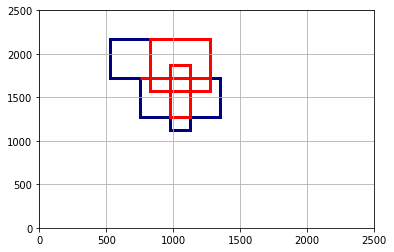

In [267]:
fig = plt.figure()
ax = fig.add_subplot(111)

for rect in tlbr:
    tl = rect[0]
    br = rect[1]
    h = br[1] - tl[1]
    w = br[0] - tl[0]
    rect = matplotlib.patches.Rectangle(tl, w, h, fill=False, edgecolor='navy', linewidth=3)
    ax.add_patch(rect)

    
for i in range(len(tlbr) - 1):
    for j in range(i+1, len(tlbr)):
        rectInter = getIntersectionPointRectangles(tlbr[i], tlbr[j])
        if rectInter is None:
            continue
        tl = rectInter[0]
        br = rectInter[1]
        h = br[1] - tl[1]
        w = br[0] - tl[0]
        rect = matplotlib.patches.Rectangle(tl, w, h, fill=False, edgecolor='red', linewidth=3)
        ax.add_patch(rect)
        
plt.xlim([0, 2500])
plt.ylim([0, 2500])
plt.grid()
plt.show() 

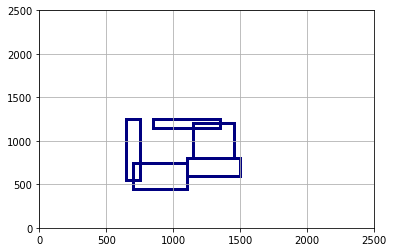

In [205]:
# Problem if rectangles have common edge

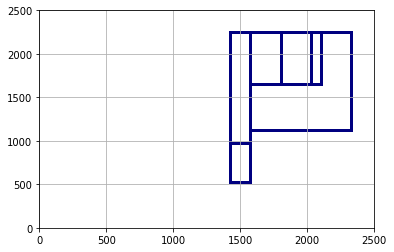

In [212]:
# example 3

In [171]:
def tlbr2points(tlbr):
    tl, br = tlbr[0], tlbr[1]
    h = br[1] - tl[1]
    w = br[0] - tl[0]
    return [list(tl), [tl[0], tl[1] + h], [tl[0] + w, tl[1] + h], [tl[0] + w, tl[1]]]

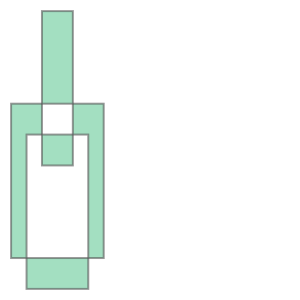

In [179]:
from matplotlib import pyplot
from shapely.geometry import Point
from descartes import PolygonPatch

a = Polygon(tlbr2points(tlbr[0]))
b = Polygon(tlbr2points(tlbr[1]))
c = Polygon(tlbr2points(tlbr[2]))
u = c.symmetric_difference(a.symmetric_difference(b))
u

In [180]:
print(u)

MULTIPOLYGON (((700 450, 700 550, 900 550, 900 450, 700 450)), ((750 950, 700 950, 700 550, 650 550, 650 1050, 750 1050, 750 950)), ((750 950, 850 950, 850 850, 750 850, 750 950)), ((900 550, 900 950, 850 950, 850 1050, 950 1050, 950 550, 900 550)), ((750 1050, 750 1350, 850 1350, 850 1050, 750 1050)))


In [143]:
tlbr

[((1050.0, 600.0), (1150.0, 1150.0)),
 ((1050.0, 650.0), (1550.0, 1150.0)),
 ((1200.0, 650.0), (1600.0, 750.0))]

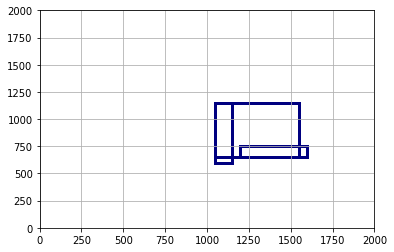

In [146]:
import matplotlib 
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
for rect in tlbr:
    tl = rect[0]
    br = rect[1]
    h = br[1] - tl[1]
    w = br[0] - tl[0]
    rect = matplotlib.patches.Rectangle(tl, w, h, fill=False, edgecolor='navy', linewidth=3)
    ax.add_patch(rect)

plt.xlim([0, 2000])
plt.ylim([0, 2000])
plt.grid()
plt.show() 

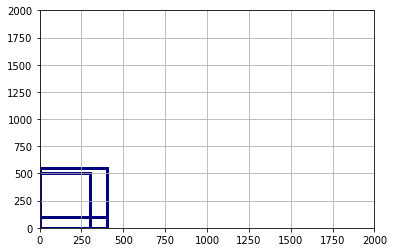

In [58]:
import matplotlib 
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
for rect in boxes:
    x, y = 0, 0
    w, h = rect[2], rect[3]
    rect = matplotlib.patches.Rectangle((x,y), w, h, fill=False, edgecolor='navy', linewidth=3)
    ax.add_patch(rect)

plt.xlim([0, 2000])
plt.ylim([0, 2000])
plt.grid()
plt.show() 

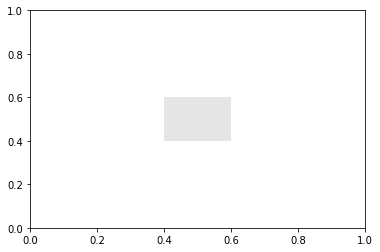

In [35]:
someX, someY = 0.5, 0.5
fig,ax = plt.subplots()
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((someX - 0.1, someY - 0.1), 0.2, 0.2,
                      alpha=0.1, facecolor='black'))
currentAxis.add_patch(Rectangle((10 - 0.1, 10 - 0.1), 0.2, 0.2,
                      alpha=0.1, facecolor='black'))
plt.show()

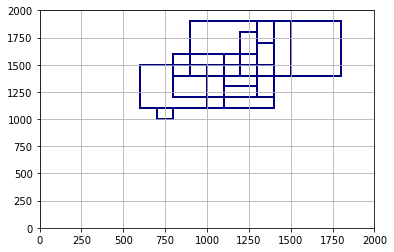

In [103]:
import matplotlib 
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

for rect in boxes:
    x, y = rect[0], rect[1]
    w, h = rect[2], rect[3]
    rect = matplotlib.patches.Rectangle((x,y), w, h, fill=False, edgecolor='navy', linewidth=2)
    ax.add_patch(rect)

plt.xlim([0, 2000])
plt.ylim([0, 2000])
plt.grid()
plt.show() 

## Find polygon contour from image

eps= 30.976568541526795


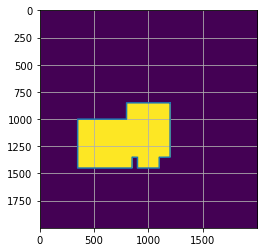

In [333]:
import cv2
import numpy as np
 
img = cv2.imread('output.jpg',0)
ret,thresh = cv2.threshold(img,127,255,0)
contours,hierarchy = cv2.findContours(thresh, 1, 2) 
cnt = contours[0]
M = cv2.moments(cnt)

epsilon = 0.01 * cv2.arcLength(cnt,True)
print('eps=',epsilon)
approx = cv2.approxPolyDP(cnt,epsilon,True)
poly_x = approx[:, :, 0]
poly_x = np.append(poly_x, approx[:, :, 0][0])
poly_y = approx[:, :, 1]
poly_y = np.append(poly_y, approx[:, :, 1][0])
plt.imshow(img)
drawPolygonByHull(poly_x, poly_y)

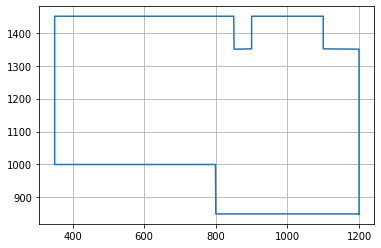

In [335]:
drawPolygonByHull(poly_x, poly_y )

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [213]:
# https://stackoverflow.com/questions/57258173/opencv-join-contours-when-rectangle-overlaps-another-rect
    
import cv2
import numpy as np
# Read image
src = cv2.imread("3E3MT.jpg", cv2.IMREAD_GRAYSCALE)

# Set threshold and maxValue
thresh = 150 
maxValue = 200
# set an initial minimal contour size
minContourSize = 250
# create a window  (needed for use with trackbar)
cv2.namedWindow("Contour")

def setMinSize(val):
        # set the minimal contour size and find/draw contours
        global minContourSize
        minContourSize = val
        doContours()

def doContours():
        # create a copy of the image (needed for use with trackbar)
        res = src.copy()
        # find contours - external only
        countours,hierarchy=cv2.findContours(dst,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        # create an empty mask
        mask = np.zeros(src.shape[:2],dtype=np.uint8)
        # draw filled boundingrects if the contour is large enough
        for c in countours:
                if cv2.contourArea(c) > minContourSize:
                        x,y,w,h  = cv2.boundingRect(c)
                        cv2.rectangle(mask,(x,y),(x+w,y+h),(255),-1)

        # find the contours on the mask (with solid drawn shapes) and draw outline on input image
        countours,hierarchy=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        for c in countours:
                        cv2.drawContours(res,[c],0,(255,255,255),2)
        # show image
        cv2.imshow("Contour",res)

# create a trackbar to set the minContourSize - initial is set at 250,
# maximum value is currently set at 1500, you can increase it if you like
cv2.createTrackbar("minContourSize", "Contour",250,1500,setMinSize)
# Basic threshold example
th, dst = cv2.threshold(src, thresh, maxValue, cv2.THRESH_BINARY)
# Find Contours
doContours()
# waitkey to prevent program for exiting by itself
cv2.waitKey(0)
cv2.destroyAllWindows()

AttributeError: 'NoneType' object has no attribute 'copy'